In [1]:
import numpy as np
import os
import struct

In [2]:
def load_mnist(path, kind):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' %kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' %kind)
   
    with open(labels_path, 'rb') as lb_path:
        magic, n = struct.unpack('>II', lb_path.read(8))
        labels = np.fromfile(lb_path, dtype=np.uint8)
    
    with open(images_path, 'rb') as images_path:
        magic, num, rows, cols = struct.unpack(">IIII", images_path.read(16))
        images = np.fromfile(images_path, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [3]:
X_train, y_train = load_mnist('.\data', 'train')

In [4]:
X_test, y_test = load_mnist('.\data', 't10k')

In [5]:
X_train.shape

(60000, 784)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

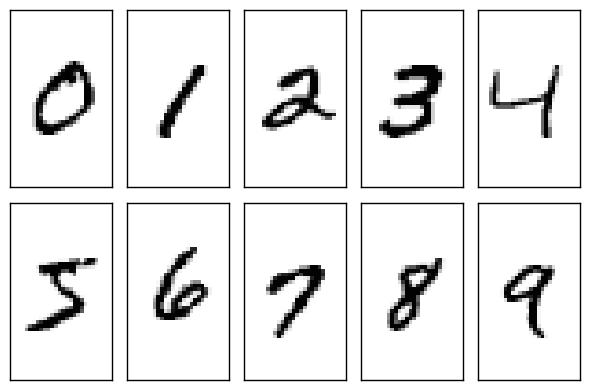

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation= 'nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()

In [8]:
from scipy.special import expit
import sys

In [47]:
class MLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, L1=0.0, L2=0.0, epochs=500, eta=0.0001, alpha=0.0, \
                 decrease_const=0.0, shuffle=True, minibatches=1, random_state=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.L1 = L1
        self.L2 = L2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.W1, self.W2 = self.__initialize_weights()
        
    def __initialize_weights(self):
        W1 = np.random.uniform(low=-1, high=1, size=self.n_hidden * (self.n_features + 1))
        W1 = W1.reshape((self.n_hidden, self.n_features + 1))
        
        W2 = np.random.uniform(low=-1, high=1, size=self.n_output * (self.n_hidden + 1))
        W2 = W2.reshape((self.n_output, self.n_hidden + 1))
        
        return W1, W2
    
    def __sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def __sigmoid_gradient(self, z):
        sg = self.__sigmoid(z)
        return sg * (1-sg)
    
    def __feedforward(self, X, W1, W2):
        N = np.ones((X.shape[0], X.shape[1]+1),dtype=np.int8)
        N[:,1:] = X
        A1 = N #(n,k')
        
        Z2 = W1.dot(A1.T)
        A2 = self.__sigmoid(Z2)#(h,n)
        
        N = np.ones((A2.shape[0]+1, A2.shape[1]),dtype=np.int8)
        N[:-1,:]=A2
        A2 = N #(h',n)
        
        Z3 = W2.dot(A2)
        A3 = self.__sigmoid(Z3)#(o,n)
        
        return Z2, Z3, A1, A2, A3
    
    
    def __l1(self, l1, W1, W2):
        return l1 * (np.sum(np.abs(W1[:,1:])) + np.sum(np.abs(W2[:,1:])))
    
    def __l2(self, l2, W1, W2):
        return l2 * (np.sum(np.power(W1[:,1:],2)) + np.sum(np.power(W2[:,1:],2)))
    
    def __getcost(self, encoding, output, W1, W2):
        cost = -encoding.dot(np.log(output)) - (1-encoding).dot(np.log(output))
        l1 = self.__l1(self.l1, W1, W2)
        l2 = self.__l2(self.l2, W1, W2)
        return cost + l1 + l2
    
    def __back_propagate(self, encoding, A3, A2, A1, Z2, Z3, W1, W2):
        #W1(h,k') and W2(o,h')
        #A1(n,k')
        #Z2(h,n) and A2(h',n)
        #Z3(o,n) and A3(o,n) and encoding(o,n)
        
        N = np.ones((Z3.shape[0] + 1, Z3.shape[0]), dtype=np.int8)
        N[:-1,:] = Z3
        Z3 = N
        
        delta3 = (A3 - encoding) * self.__sigmoid_gradient(Z3) #(o,n)
        grad3 = delta3.dot(A2.T) #(o,h')
        
        N = np.ones((Z2.shape[0] + 1, Z2.shape[0]), dtype=np.int8)
        N[:-1,:] = Z2
        Z2 = N #(h',n)
        
        delta2 = W2.T.dot(delta3) * self.__sigmoid_gradient(Z2) #(h',n)
        grad2 = delta2.dot(A1) #(h',k')  
        
        grad2[:, 1:] += W1[:, 1:] *(self.l1 + self.l2)
        grad3[:, 1:] += W2[:, 1:] *(self.l1 + self.l2)
        
        return grad2, grad3
    
    def __predict(self, X):
        A1, Z2, A2, Z3, A3 = self.__feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(Z3, axis=0)
        return y_pred
    
    def __encode(self, y):
        y_encoded = np.zeros((self.n_output, y.shape[0]))
        for i,v in enumerate(y):
            y_encoded[v, i] = 1
        return y_encoded #(o,n)
    
    def __fit(self, X, y, print_progress=False):
        self.cost = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self.__encode(y_data)
        
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        
        for i in range(self.epochs):
            self.eta /= (1 + self.decrease_const * i)
            
            sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
            sys.stderr.flush()
            
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y[:,idx]
            
            for idx in self.minibatches:
                A1, Z2, A2, Z3, A3 = self.__predict(X_data[])
                
            

## Why we take Z3 instead of A3 in predict method ?

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

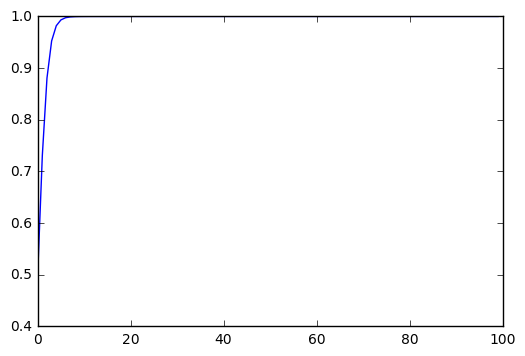

In [11]:
x = np.arange(0,100)
y = 1 / (1+ np.exp(-x))
plt.plot(x,y)

In [12]:
y

array([ 0.5       ,  0.73105858,  0.88079708,  0.95257413,  0.98201379,
        0.99330715,  0.99752738,  0.99908895,  0.99966465,  0.99987661,
        0.9999546 ,  0.9999833 ,  0.99999386,  0.99999774,  0.99999917,
        0.99999969,  0.99999989,  0.99999996,  0.99999998,  0.99999999,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [13]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [14]:
X_train.shape

(60000, 784)

In [17]:
len(np.array_split(range(y_train.shape[0]),50)[0])

1200

In [18]:
1200 *50

60000

In [20]:
np.array_split(range(100),10)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]

In [25]:
np.random.permutation([1,5,6,4,8])

array([4, 6, 1, 5, 8])

In [30]:
np.random.permutation(y_train.shape[0])

array([49412,  8537,  3923, ..., 45392, 58900, 30083])

In [35]:
mini = np.array_split(range(y_train.shape[0]), 50)
mini

[array([   0,    1,    2, ..., 1197, 1198, 1199]),
 array([1200, 1201, 1202, ..., 2397, 2398, 2399]),
 array([2400, 2401, 2402, ..., 3597, 3598, 3599]),
 array([3600, 3601, 3602, ..., 4797, 4798, 4799]),
 array([4800, 4801, 4802, ..., 5997, 5998, 5999]),
 array([6000, 6001, 6002, ..., 7197, 7198, 7199]),
 array([7200, 7201, 7202, ..., 8397, 8398, 8399]),
 array([8400, 8401, 8402, ..., 9597, 9598, 9599]),
 array([ 9600,  9601,  9602, ..., 10797, 10798, 10799]),
 array([10800, 10801, 10802, ..., 11997, 11998, 11999]),
 array([12000, 12001, 12002, ..., 13197, 13198, 13199]),
 array([13200, 13201, 13202, ..., 14397, 14398, 14399]),
 array([14400, 14401, 14402, ..., 15597, 15598, 15599]),
 array([15600, 15601, 15602, ..., 16797, 16798, 16799]),
 array([16800, 16801, 16802, ..., 17997, 17998, 17999]),
 array([18000, 18001, 18002, ..., 19197, 19198, 19199]),
 array([19200, 19201, 19202, ..., 20397, 20398, 20399]),
 array([20400, 20401, 20402, ..., 21597, 21598, 21599]),
 array([21600, 21601, 

In [37]:
sys.stderr.write("HEELLO")
sys.stderr.flush()

HEELLO

In [42]:
v = np.array([[2,5,3],[7,8,4],[4,3,5],[4,7,8],[7,7,7],[3,4,7],[8,8,8]])

In [44]:
idx = np.random.permutation(v.shape[0])
idx

array([2, 1, 3, 4, 6, 0, 5])

In [45]:
v[idx]

array([[4, 3, 5],
       [7, 8, 4],
       [4, 7, 8],
       [7, 7, 7],
       [8, 8, 8],
       [2, 5, 3],
       [3, 4, 7]])